# Big project activity

## Optimal chargin station location

### 1.Introduction

Consider a long linear cycle path  as Vento, or the Danube cycle path. The cycle path usually runs along the banks of a river with scarse tourist interest. However, from the main course of the cycle path it is possible to reach places of tourist interest by making small detours.  

The rapid growth of e-bike ridership is proposing the problem of deploying a suitable charging infrastructure. The charging stations should be placed in strategic positions so as to guarantee a coverage of the whole cycle path. However, since the charging operations require a non negligible time, the charging station should be positioned in places where alternative activities could be carried out, as restaurants, museums, swimming pool, or other amenities. Moreover, the presence of a charging station could also induce e-cyclists to discover new places and generate positive externalities.



### 2.Decision problem
We can represent the cycle path as a graph where the set of nodes $H = \{1,\ldots,n\}$ corresponds to the tourist sites that may host a charging station.
In addition we are given the distances between touristic site ($d_{ij},$ with $ i,j =1,\ldots,n$). Let $c_i$ be the cost of installing a charging station in site $i, i=1\ldots,n$.


The problem is, given a budget $b$, determine the subset of sites $S\subseteq H$ where to install the charging stations so that the total cost is not higher than $b$ and the maximum distance between consecutive charging stations is minimized.
Consider that the cyclist has to visit all the touristic destination in a consecutive way.



### 3.Problem characteristics
There are 2 csv files that contain the information of the cycle way, they are essential to build the equivalent graph:


*    in the "nodes.csv" file there are all the destinations that the cyclist can reach, with their spatial coordinates and the value of installation costs related to that destination. Consider that the "tourist-dest-id" is not the graph node number but it is an unique id to identify the destination.
*   in the "OD.csv" you can find all the arcs between two different nodes, keep attention that the condition of visiting consecutive touristic destination must be respected.

The set of nodes $N$ is defined by $\{0,1,\ldots,n, n+1\}$.  The Arcs $A$ correspond to the portion of cycle path between two consecutive charging stations. We assume that potentially e-riders will visit all sites along the way making the suitable deviations and going back to the main path at the initial point of the detour.
The cost associated with each  arc $(i,j)$ is given by $c_j$, thus the cost of installing a charging station in $j$. These costs are defined for all arcs in $A$, while they are set to 0 for all the arcs that arrive in the last node.
The path starts in node $s = 0$ and ends in node $t = n+1$, these two nodes are connected to the nearest touristic site with an arc of null length.

### 4.Example of linear path with deviation
![picture](https://drive.google.com/uc?export=view&id=1w16bHtbu0FGGL-UntxeqxD7244D3eHbJ)

### 5.Requirements
The requirements of the problem are:


*   the maximum running time of the algorithm must be 5 minutes, so set the proper timer
*   create the equivalent graph and display it on a xy-plot
*   find the solution for the basic scenario, with a mip model, displaying the solution with a xy-plot, the budget constrain is $b = 10000\ € $.
*   Find the optimal solution for 5 different values of budget in the range $[10000, 100000]$. Select the values of the budget so as to have different charger locations.

  You have to motivate you choice and the solution you get. They can also be not common solution if they are well motivated. To support your decision and explanations you can print plots or tables. You can also compare different scenarios.


   
If you have some doubts related to the parametric analysis prof. Cubillos uploaded a notebook with the solution on WeBeeP and you can have a look there.

### Insert student name and student ID

student1: Leonardo Bianconi

ID1: 10660229 (matricola 232004)

student2: Marco Cerino

ID2: 11011193 (matricola 244780)

student3: Mattia De Bartolomeis

ID3: 10730974 (matricola 245022)



In [1]:
#install libraries

!pip install mip
!pip install --upgrade cffi==1.15.0


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
#import libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import mip
import pandas as pd
import importlib
import cffi
importlib.reload(cffi)
import numpy as np
import math
import networkx as nx
import time

In [3]:
#import the csv files
nodes_df = pd.read_csv("https://raw.githubusercontent.com/leo-bianconi/for-big-project/main/nodes.csv", encoding='cp1252')  # changed the encoding to handle non-utf symbol (Euro symbol)
arcs_df = pd.read_csv("https://raw.githubusercontent.com/leo-bianconi/for-big-project/main/OD.csv")

In [4]:
#set the timer
start_time = time.time()

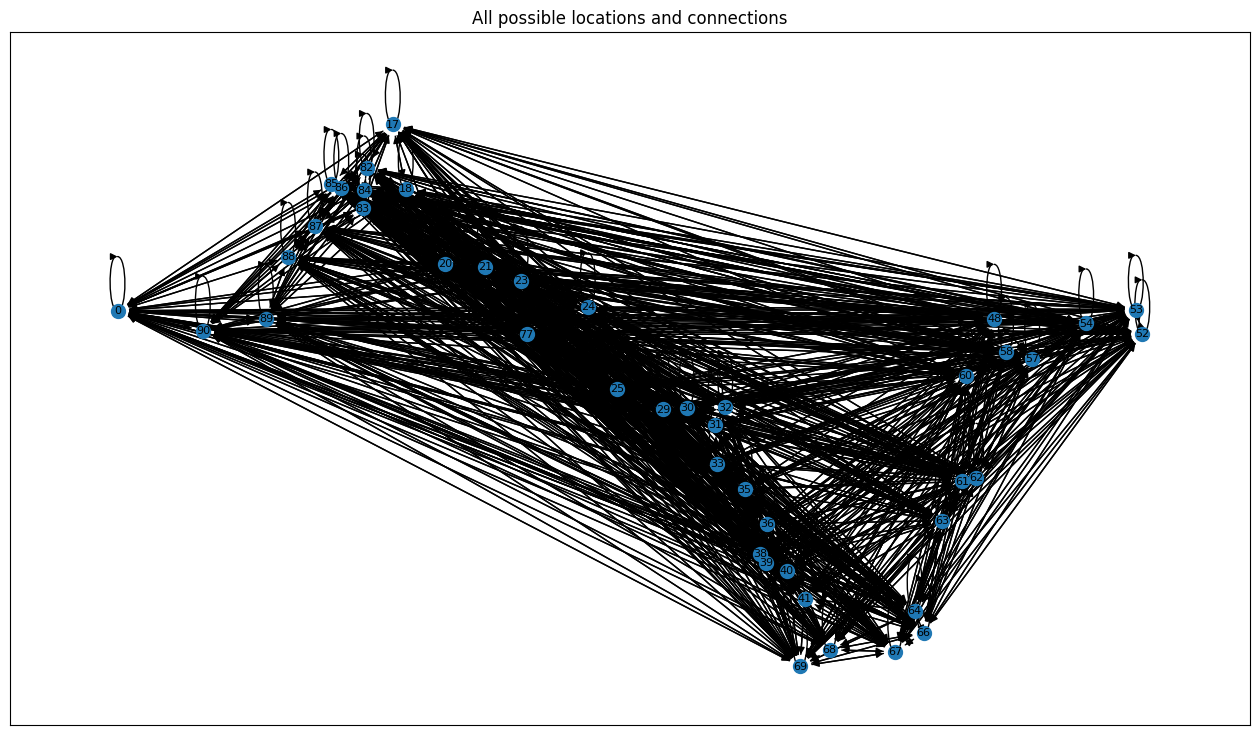

In [5]:
#build the equivalent graph
G = nx.DiGraph()  # directed graph

#define the set of nodes
N = set()
for index, node in nodes_df.iterrows():
    N.add(node.tourist_dest_id)

n = len(N)

#define the set of edges
A = set()
for idx, arc in arcs_df.iterrows():
    i = int(arc.origin_id)
    j = int(arc.destination_id)
    A.add((i, j))

#build the graph
G.add_nodes_from(N)
G.add_edges_from(A)

pos = {id: (pos_x, pos_y) for id, pos_x, pos_y in nodes_df[['tourist_dest_id', 'x (longitude)', 'y (latitude)']].values}

#draw the graph
plt.figure(figsize=(16,9))
plt.title(f"All possible locations and connections")
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_labels(G,pos=pos, font_size=8)
nx.draw_networkx_edges(G, edgelist=A, pos=pos);  # semicolon to suppress unwanted printing

In [6]:
# euclidean distance matrix (using coordinates of the points, i.e. air-line distance)
def euclidean_distance(i, j):
    (i_x, i_y) = nodes_df.loc[(nodes_df['tourist_dest_id'] == i), ('x (longitude)', 'y (latitude)')].values[0]
    (j_x, j_y) = nodes_df.loc[(nodes_df['tourist_dest_id'] == j), ('x (longitude)', 'y (latitude)')].values[0]
    return math.sqrt((i_x - j_x)**2 + (i_y - j_y)**2)

euclidean_distance_dict = {(i, j) : euclidean_distance(i, j) for j in N for i in N}

# distance between each node as given in the OD.csv file (road distance)
def road_distance(i, j):
    if i == j: return 0
    res = arcs_df.loc[(arcs_df['origin_id'] == i) & (arcs_df['destination_id'] == j), 'distance [m]'].values[0]
    return res

The selected starting node is 0.
This is the TSP path from initial node 0:
[0, 90, 89, 88, 87, 85, 86, 83, 84, 82, 17, 18, 20, 21, 23, 77, 24, 25, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 69, 68, 67, 64, 66, 63, 61, 62, 60, 48, 58, 57, 54, 53, 52]


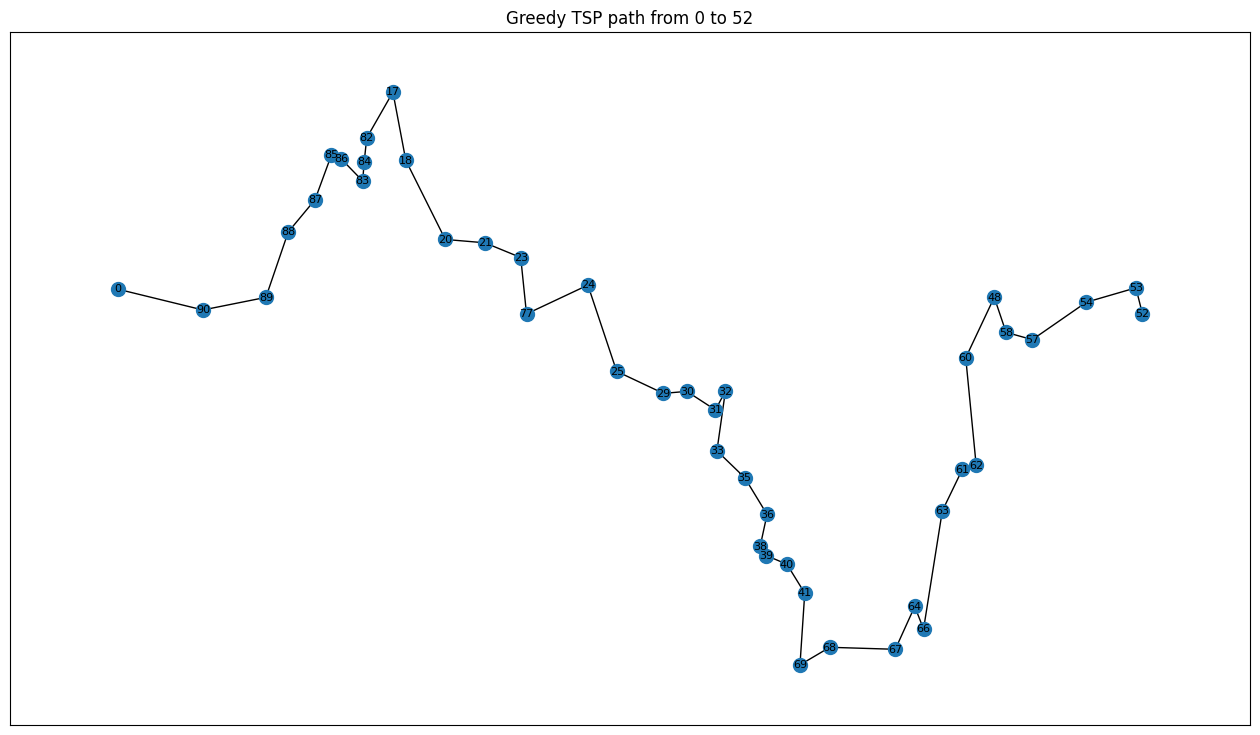

In [7]:
# Find the first node by searching for the one with the smallest longitude
starting_node = nodes_df.nsmallest(n=1, columns='x (longitude)').squeeze()['tourist_dest_id']
print(f'The selected starting node is {starting_node}.')

# find the greedy TSP path (look at the closest node at every iteration, starting from the node found before)

def greedy_path(starting_node):
    path = [starting_node]
    i = 0
    still_to_choose = list(N)
    still_to_choose.remove(starting_node)
    while len(path) < len(N):
        dists = [ euclidean_distance_dict[(node, path[i])] for node in still_to_choose ]
        i_star = np.argmin(dists)
        path.append(still_to_choose[i_star])
        still_to_choose.pop(i_star)
        i += 1

    return path

tsp_path = greedy_path(starting_node=starting_node)                                     # ordered sequence of nodes
tsp_path_edges = [(tsp_path[i], tsp_path[i+1]) for i in range(len(tsp_path) - 1)]       # ordered sequence of arcs

# print the path
print(f"This is the TSP path from initial node {starting_node}:")
print(tsp_path)

# draw the path
plt.figure(figsize=(16,9))
plt.title(f"Greedy TSP path from {tsp_path[0]} to {tsp_path[-1]}")
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_labels(G,pos=pos, font_size=8)
nx.draw_networkx_edges(G, edgelist=tsp_path_edges, pos=pos, arrows=False);  # semicolon to suppress unwanted printing

In [8]:
# find starting and ending node in the TSP path
s = tsp_path[0]
t = tsp_path[-1]

# cost of installing a charging station after stage (i, j)
def c(i, j):
    if j == t: return 0
    return nodes_df.loc[(nodes_df['tourist_dest_id'] == j), 'Cost_of_installation [€]'].values[0]

# distance of a stage (sum of the road distances)
def d_stage(i, j):
    i_idx, j_idx = tsp_path.index(i), tsp_path.index(j)
    if i_idx >= j_idx: return math.inf
    sub_path = tsp_path[i_idx:j_idx+1]
    return sum(road_distance(sub_path[k], sub_path[k+1]) for k in range(len(sub_path)-1))

# maximum distance for a stage (additional requirement)
max_stage_dist = 50000

# create the logical graph
N_logical = N
A_logical = {}
for i in range(len(tsp_path)):
    for j in range(i+1, len(tsp_path)):
        dist = d_stage(tsp_path[i], tsp_path[j])
        if dist < max_stage_dist:
            A_logical[(tsp_path[i], tsp_path[j])] = dist

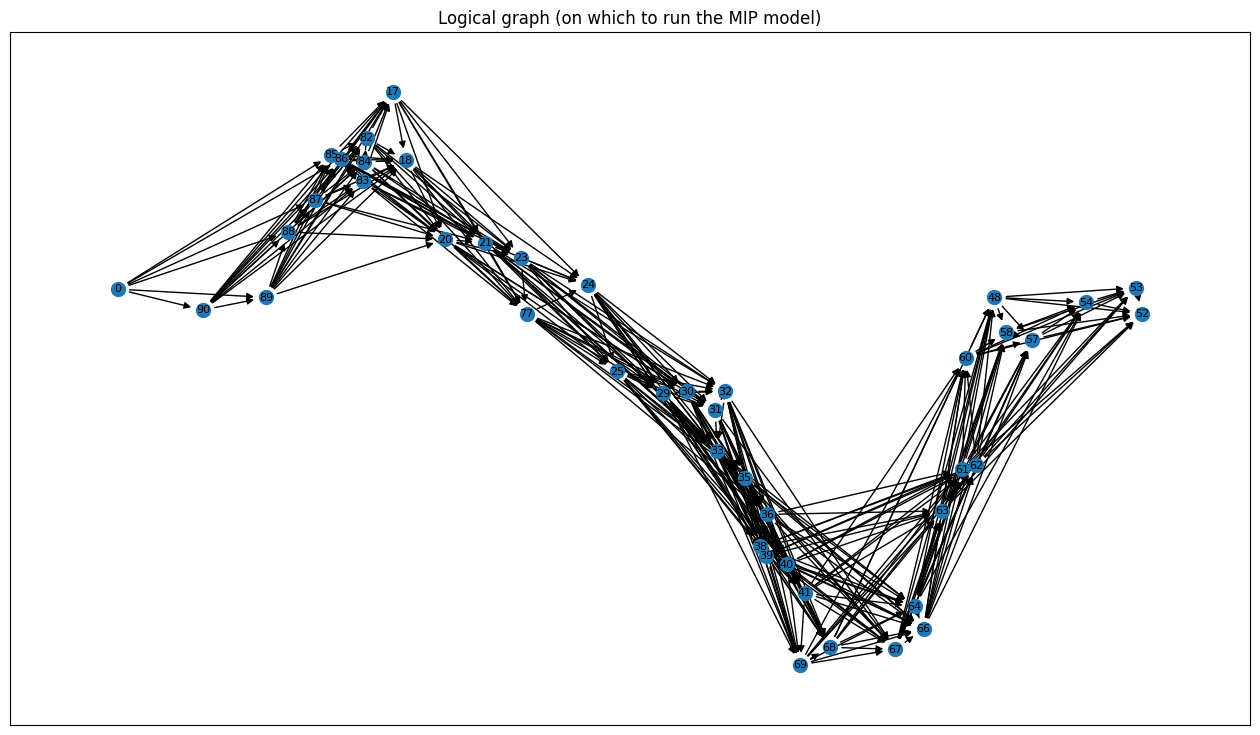

In [9]:
G = nx.DiGraph()
G.add_nodes_from(N)
G.add_edges_from(A_logical)

# print the logical graph
plt.figure(figsize=(16,9))
plt.title(f"Logical graph (on which to run the MIP model)")
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_edges(G, pos=pos)
nx.draw_networkx_labels(G,pos=pos, font_size=8);

In [10]:
# Create model
m = mip.Model()

# define the variables
x = {(i, j): m.add_var(var_type=mip.BINARY) for (i, j) in A_logical}            # decisions: arc (i, j) belongs to the path
D = m.add_var()                                                                 # dummy variable for min-max linearization

#  define the contraints
m.add_constr( mip.xsum(x[(i, j)] for (i, j) in A_logical if i == s) == 1 )      # source node -> 1 outgoing arc
m.add_constr( mip.xsum(x[(i, j)] for (i, j) in A_logical if j == t) == 1 )      # destination node -> 1 ingoing arc

# two arcs or zero for each other node
for i in N:
  if i not in [s, t]:
    m.add_constr( mip.xsum(x[(n_in, n_out)] for n_in, n_out in A_logical if n_out == i)
                  - mip.xsum(x[(n_in, n_out)] for n_in, n_out in A_logical if n_in == i) == 0 )

budget = 10000
m.add_constr( mip.xsum(x[(i, j)] * c(i, j) for i, j in A_logical) <= budget )   # budget constraint

for (i, j) in A_logical:
  m.add_constr( D >= x[(i, j)] * A_logical[(i, j)] )                            # dummy variable constraints

# optimize objective function
m.objective = mip.minimize( D )

m.optimize()

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Dual Simplex

Clp0024I Matrix will be packed to eliminate 9 small elements
Coin0506I Presolve 399 (0) rows, 355 (0) columns and 1761 (0) elements
Clp0014I Perturbing problem by 0.001% of 412.85965 - largest nonzero change 0.00037957891 ( 9.193897e-05%) - largest zero change 0.00037890136
Clp0000I Optimal - objective value 5103.1085
Clp0032I Optimal objective 5103.108494 - 124 iterations time 0.002

Starting MIP optimization
Cgl0004I processed model has 399 rows, 355 columns (354 integer (354 of which binary)) and 1761 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.197%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0045I Nauty did not find any useful orbits in time 0.001898
Cbc0038I Initial state - 70 integers unsatisfied sum - 6.88794
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 49871.7 iterations 1

<OptimizationStatus.OPTIMAL: 0>

In [11]:
# print solution details
print(f"Objective function (max distance between stops): {D.x}")
print(f"Total cost for this solution: {mip.xsum(x[(i, j)].x * c(i, j) for i, j in A_logical)} (budget: {budget})")

# get the stops and stages from the model optimized variables
def get_stops(x):
  path_stages = []
  for t, x_i in x.items():
    if x_i.x != 0:
      path_stages.append(t)
  stops = list(sum(path_stages, ()))
  stops = list(dict.fromkeys(stops))
  return (stops, path_stages)

stops, path_stages = get_stops(x)
print("Stops selected:")
print(stops)

Objective function (max distance between stops): 38228.51958
Total cost for this solution: + 9506.0 (budget: 10000)
Stops selected:
[0, 89, 18, 77, 32, 68, 60, 52]


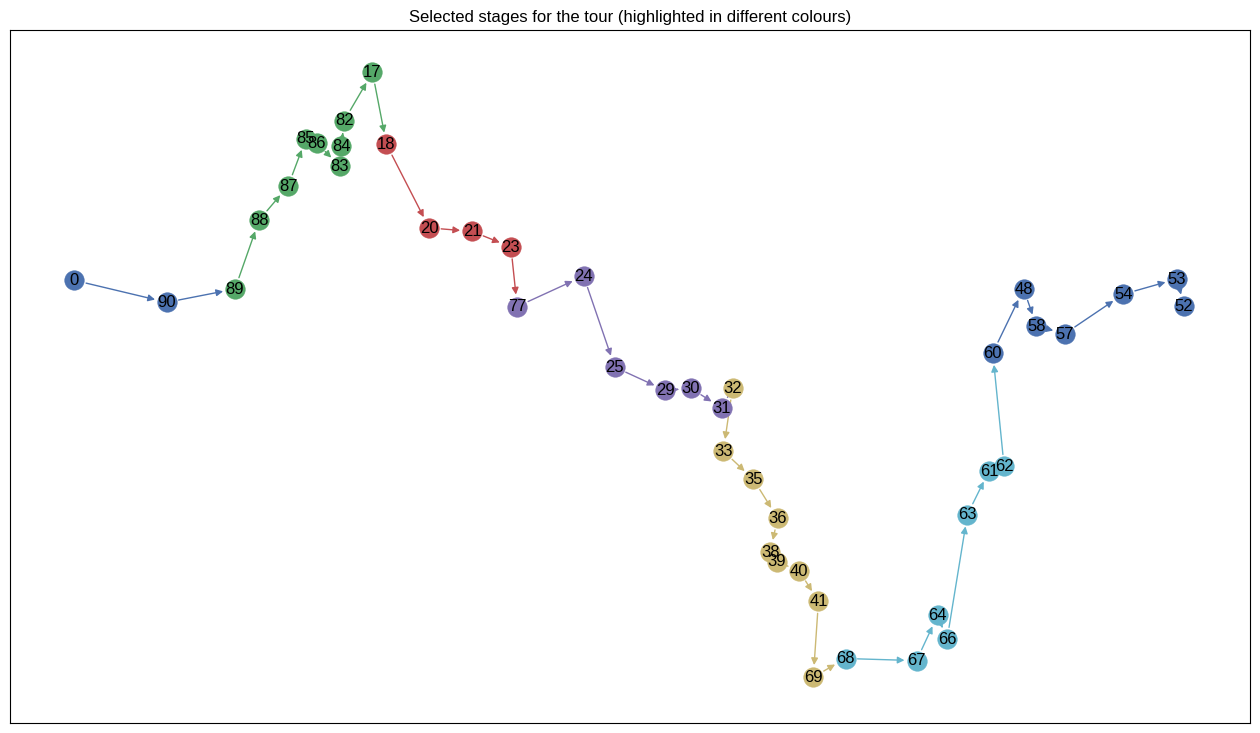

In [12]:
#plot the graph
G = nx.DiGraph()
G.add_nodes_from(N)
G.add_edges_from(path_stages)

plt.figure(figsize=(16,9))
plt.title(f"Selected stages for the tour (highlighted in different colours)")
mpl.style.use('seaborn-v0_8')

for i in range(len(stops)-1):
  idx_start, idx_stop = tsp_path.index(stops[i]), tsp_path.index(stops[i+1])
  nx.draw_networkx_nodes(G, pos=pos, node_size=200, nodelist=tsp_path[idx_start:idx_stop], node_color=f"C{i}")
  nx.draw_networkx_edges(G, edgelist=tsp_path_edges[idx_start:idx_stop], pos=pos, edge_color=f"C{i}")

nx.draw_networkx_nodes(G, nodelist=[tsp_path[-1]], pos=pos, node_color=f"C{len(stops)-2}", node_size=200)
nx.draw_networkx_labels(G,pos=pos, font_size=12);

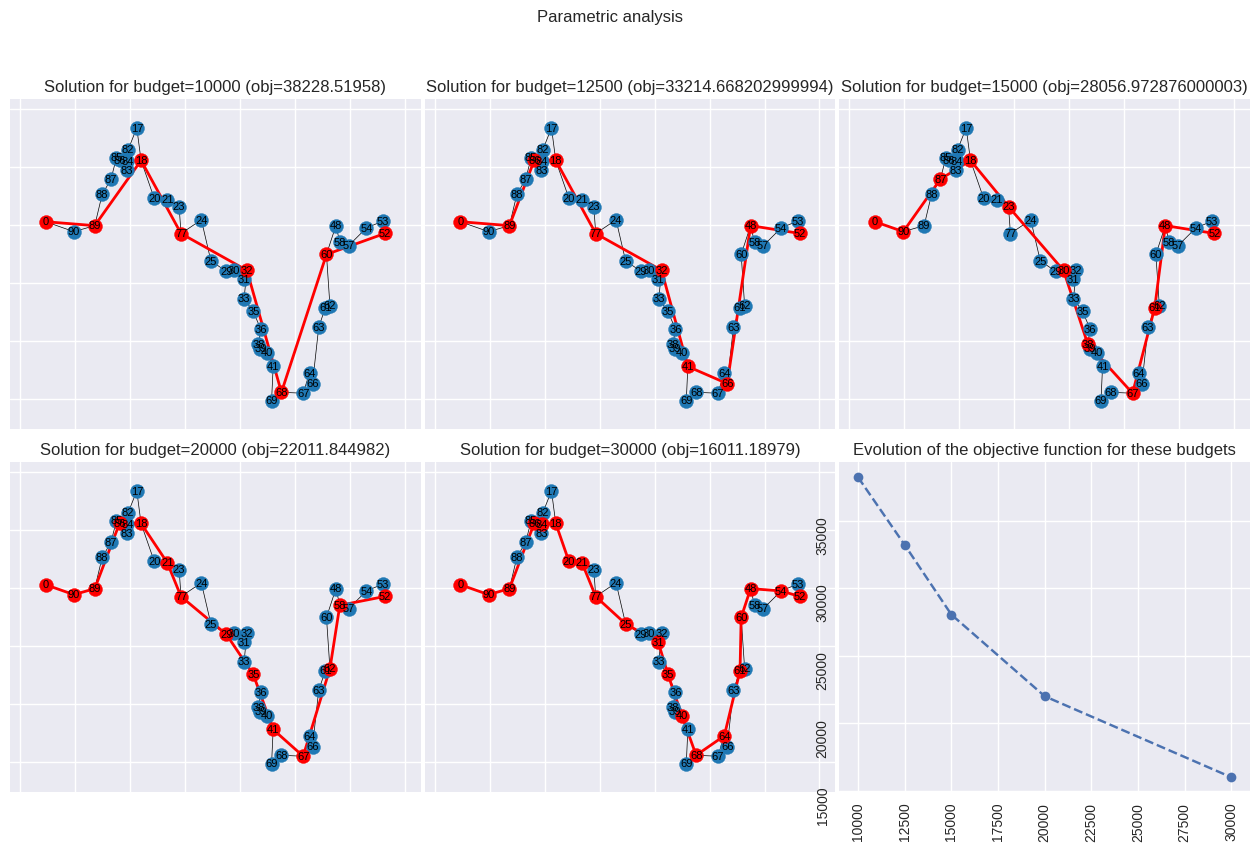

In [13]:
# parametric analysis

def solve_model(budget):
  # Create model
  m = mip.Model()
  m.verbose = 0
  # define the variables
  x = {(i, j): m.add_var(var_type=mip.BINARY) for (i, j) in A_logical}            # decisions: arc (i, j) belongs to the path
  D = m.add_var()                                                                 # dummy variable for min-max linearization

  #  define the contraints
  m.add_constr( mip.xsum(x[(i, j)] for (i, j) in A_logical if i == s) == 1 )      # source node -> 1 outgoing arc
  m.add_constr( mip.xsum(x[(i, j)] for (i, j) in A_logical if j == t) == 1 )      # destination node -> 1 ingoing arc

  # two arcs or zero for each other node
  for i in N:
    if i not in [s, t]:
      m.add_constr( mip.xsum(x[(n_in, n_out)] for n_in, n_out in A_logical if n_out == i)
                    - mip.xsum(x[(n_in, n_out)] for n_in, n_out in A_logical if n_in == i) == 0 )

  m.add_constr( mip.xsum(x[(i, j)] * c(i, j) for i, j in A_logical) <= budget )   # budget constraint (parametric)

  for (i, j) in A_logical:
    m.add_constr( D >= x[(i, j)] * A_logical[(i, j)] )                            # dummy variable constraints

  # optimize objective function
  m.objective = mip.minimize( D )

  m.optimize()
  return (m, get_stops(x), m.objective_value)

# solve for different budgets and plot solutions
budgets = [10000, 12500, 15000, 20000, 30000]
objectives = []

# plot graphs corresponding to the different solutions
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(9)
fig.set_figwidth(16)
fig.suptitle("Parametric analysis")
axs = axs.ravel()

for i in range(len(budgets)): 
  m, (stops, stages), obj = solve_model(budgets[i])
  objectives.append(obj)
  axs[i].set_title(f"Solution for budget={budgets[i]} (obj={objectives[i]})")
  axs[i].set_yticklabels([])
  axs[i].set_xticklabels([])
  G = nx.DiGraph()
  G.add_nodes_from(N)
  G.add_edges_from(stages)
  nx.draw_networkx_nodes(G, pos=pos, node_size=100, nodelist=N-set(stops), ax=axs[i])
  nx.draw_networkx_nodes(G, pos=pos, node_size=100, nodelist=stops, node_color="red", ax=axs[i])
  nx.draw_networkx_edges(G, edgelist=tsp_path_edges, pos=pos, ax=axs[i], width=.5, arrows=False)
  nx.draw_networkx_edges(G, edgelist=stages, pos=pos, edge_color="red", width=2, ax=axs[i], arrows=False)
  nx.draw_networkx_labels(G,pos=pos, font_size=8, ax=axs[i])

# plot line graph of objective value as a function of budget
axs[5].tick_params(labelrotation=90)
axs[5].set_title("Evolution of the objective function for these budgets")
axs[5].plot(budgets, objectives, "--o")
plt.subplots_adjust(wspace=.01, hspace=.1)

In [14]:
# print elapsed time

end_time = time.time()
print(f"Total elapsed time for the notebook: {int((end_time - start_time))//60} minutes {(end_time - start_time)%60:.2f} seconds")

Total elapsed time for the notebook: 0 minutes 14.52 seconds
